In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [34]:
import sys

d = '/Users/wfarr/Code/pydelfi'
try:
    sys.path.index(d)
except ValueError:
    sys.path.append(d)

import h5py
    
from pydelfi import delfi
import pydelfi.ndes as ndes
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf

import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u

import scipy.stats as ss

%pylab inline

import seaborn as sns

sns.set_style('ticks')
sns.set_palette('colorblind')
sns.set_context('notebook')

Populating the interactive namespace from numpy and matplotlib


In [55]:
with h5py.File('observations.h5', 'r') as f:
    m1det = array(f['posteriors/m1det'])
    dldet = array(f['posteriors/dl'])

In [66]:
dlbins = linspace(0, np.max(dldet), 13)

m90s = []

for j in range(dldet.shape[1]):
    d = dldet[:,j]
    m = m1det[:,j]
    
    m9 = []
    for l,h in zip(dlbins[:-1], dlbins[1:]):
        s = (l <= d) & (d < h)
        if count_nonzero(s) > 0:
            m9.append(percentile(m[s], 90))
        else:
            m9.append(0)
    
    m90s.append(m9)
m90s = array(m90s)

In [67]:
m90s.shape

(4000, 12)

In [72]:
for i in range(m90s.shape[1]):
    print(i, np.any(m90s[:,i]==0))

0 False
1 False
2 False
3 False
4 False
5 False
6 True
7 True
8 True
9 True
10 True
11 True


<ErrorbarContainer object of 3 artists>

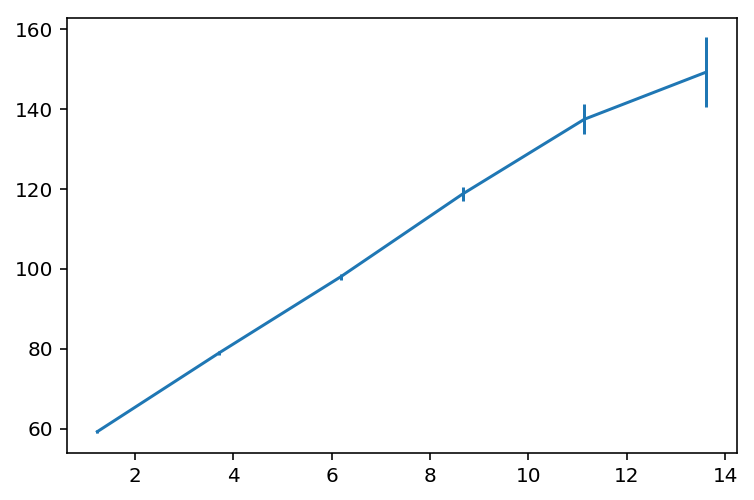

In [74]:
errorbar(0.5*(dlbins[1:]+dlbins[:-1])[:6], mean(m90s, axis=0)[:6], std(m90s, axis=0)[:6])

In [76]:
0.5*(dlbins[1:] + dlbins[:-1])[:6]

array([ 1.23766646,  3.71299937,  6.18833228,  8.66366519, 11.1389981 ,
       13.61433102])

In [75]:
std(m90s, axis=0)[:6]

array([0.30114003, 0.40301369, 0.76958809, 1.82501409, 3.80806915,
       8.68298521])

In [3]:
dls = array([ 1.23766646,  3.71299937,  6.18833228,  8.66366519, 11.1389981 ,
       13.61433102])
sigmas = array([0.30114003, 0.40301369, 0.76958809, 1.82501409, 3.80806915,
       8.68298521])

m90_0 = 52.0

def simulator(theta, seed=None, simulator_args=None, batch=None):
    if seed is not None:
        np.random.seed(seed)
        
    h0, Om, w, m90 = theta
    #h0 = Planck15.H0.to(u.km/u.s/u.Mpc).value
    #Om = Planck15.Om0
    #w = theta[0]
    #m90 = m90_0
    
    
    c = cosmo.FlatwCDM(h0*u.km/u.s/u.Mpc, Om, w)
        
    zs = array([cosmo.z_at_value(c.luminosity_distance, d*u.Gpc) for d in dls])
    
    return m90*(1+zs) + sigmas*randn(len(dls))

In [4]:
theta_fiducial = array([Planck15.H0.to(u.km/u.s/u.Mpc).value, Planck15.Om0, -1.0, m90_0])
#theta_fiducial = array([-1.0])

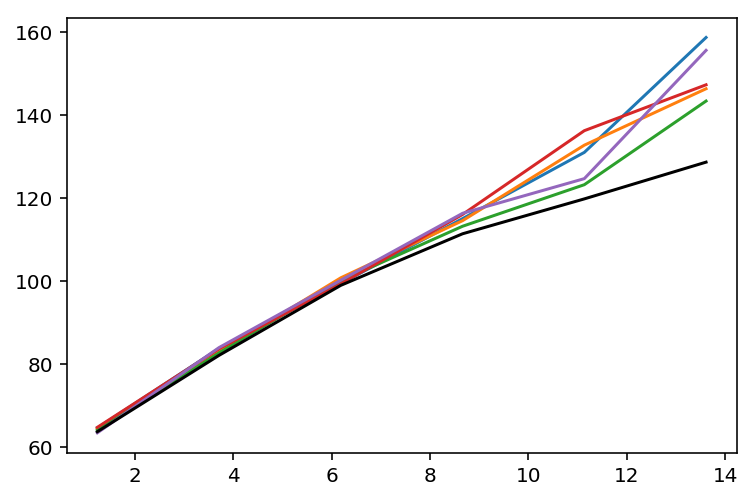

In [5]:
plot(dls, simulator(theta_fiducial))
plot(dls, simulator(theta_fiducial))
plot(dls, simulator(theta_fiducial))
plot(dls, simulator(theta_fiducial))
plot(dls, simulator(theta_fiducial))

plot(dls, simulator(theta_fiducial + array([0.0, 0, -0.5, 0.0])), '-k')

In [6]:
prior_low = array([35.0, 0.0, -2.0, 30.0])
prior_high = array([140.0, 0.75, 0.0, 85.0])

# Use these priors if you just want to measure w:
#prior_C = np.diag([(0.01*theta_fiducial[0])**2, (0.01*theta_fiducial[1])**2, 0.5**2, 10.0**2])

# Use these priors if you don't want to measure w, but want to just constrain cosmology:
prior_C = np.diag([15**2, 0.15**2, 0.5**2, 10.0**2])

prior = priors.TruncatedGaussian(theta_fiducial, prior_C, prior_low, prior_high)

In [7]:
compressor = score.Gaussian(len(simulator(theta_fiducial)), theta_fiducial, prior_mean=theta_fiducial, prior_covariance=prior_C)

In [8]:
compressor.compute_mean_covariance(simulator, 250)
compressor.compute_derivatives(simulator, 250, abs(0.01*theta_fiducial))

In [10]:
compressor.compute_fisher()

In [11]:
sqrt(diag(compressor.Finv))

array([8.97303109, 0.10859719, 0.4387009 , 0.93896928])

In [8]:
def compress(d, cargs=None):
    return compressor.scoreMLE(d)

In [13]:
t0 = compress(simulator(theta_fiducial))

In [14]:
npar = len(t0)
ndim = len(t0)
NDEs = [ndes.MixtureDensityNetwork(n_parameters=npar, n_data=ndim, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=0),
       ndes.MixtureDensityNetwork(n_parameters=npar, n_data=ndim, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
       ndes.MixtureDensityNetwork(n_parameters=npar, n_data=ndim, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
       ndes.MixtureDensityNetwork(n_parameters=npar, n_data=ndim, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
       ndes.MixtureDensityNetwork(n_parameters=npar, n_data=ndim, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
       ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=npar, n_data=ndim, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=5)]

DelfiEnsemble = delfi.Delfi(t0, prior, NDEs, Finv=compressor.Finv, theta_fiducial=theta_fiducial, 
                       param_limits = [prior_low, prior_high],
                       param_names = [r'H_0', r'\Omega_M', r'w', r'M_{90}'],
                       results_dir = "./LFI/",
                       input_normalization="fisher")

Instructions for updating:
Colocations handled automatically by placer.


/Users/wfarr/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint
Sampling approximate posterior...
Done.
Removed no burn in


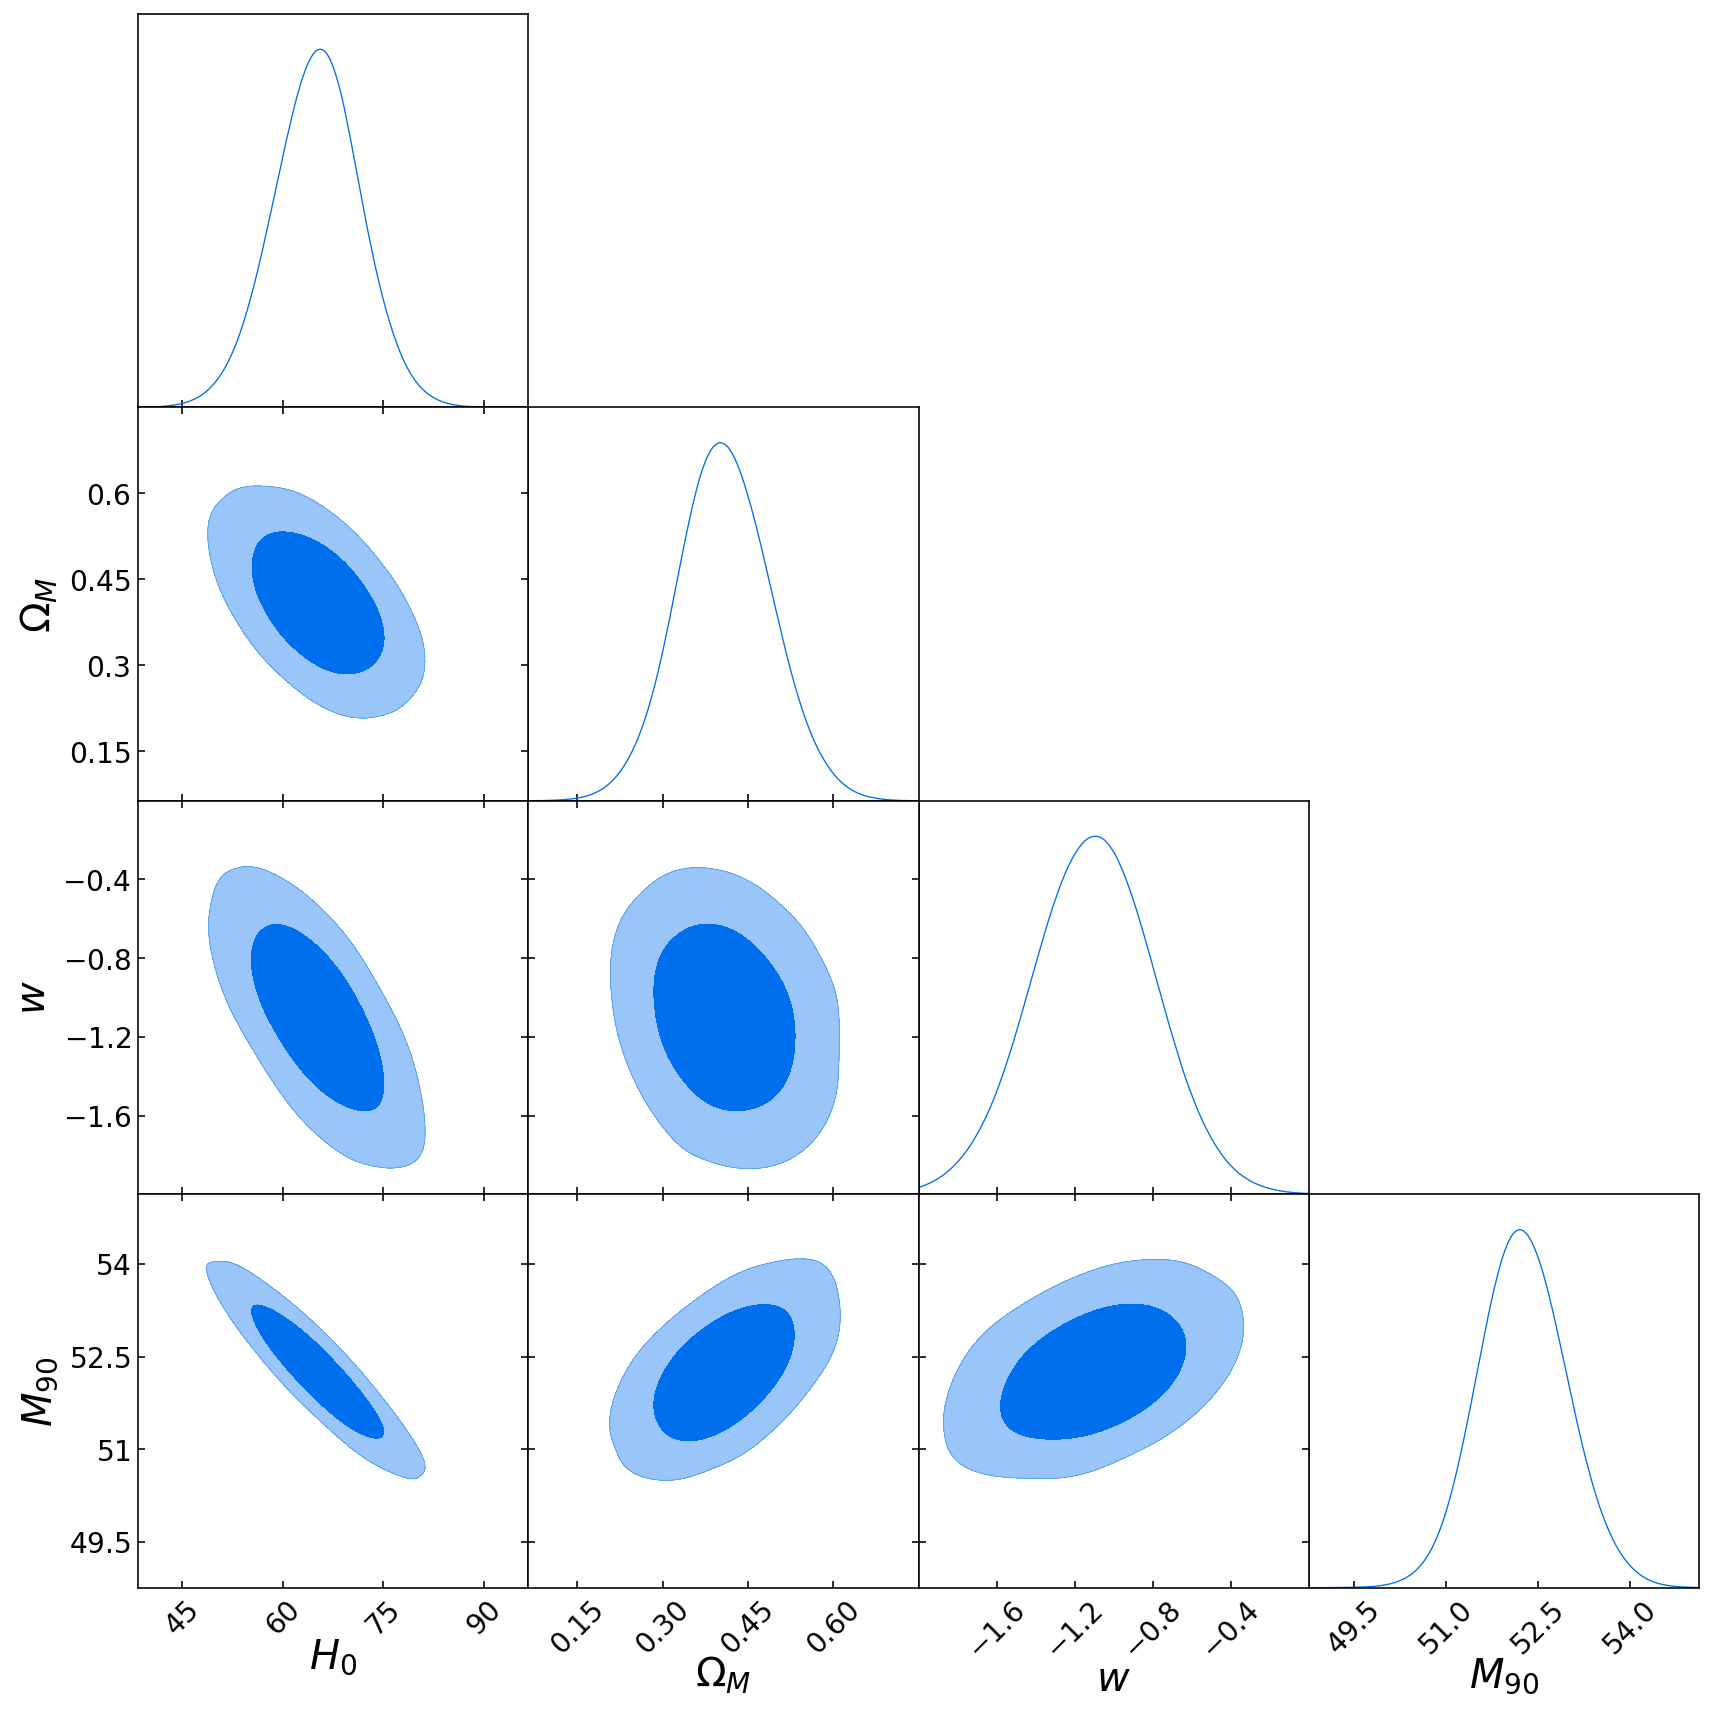

In [15]:
DelfiEnsemble.fisher_pretraining()

INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


Sampling approximate posterior...
Done.
Removed no burn in


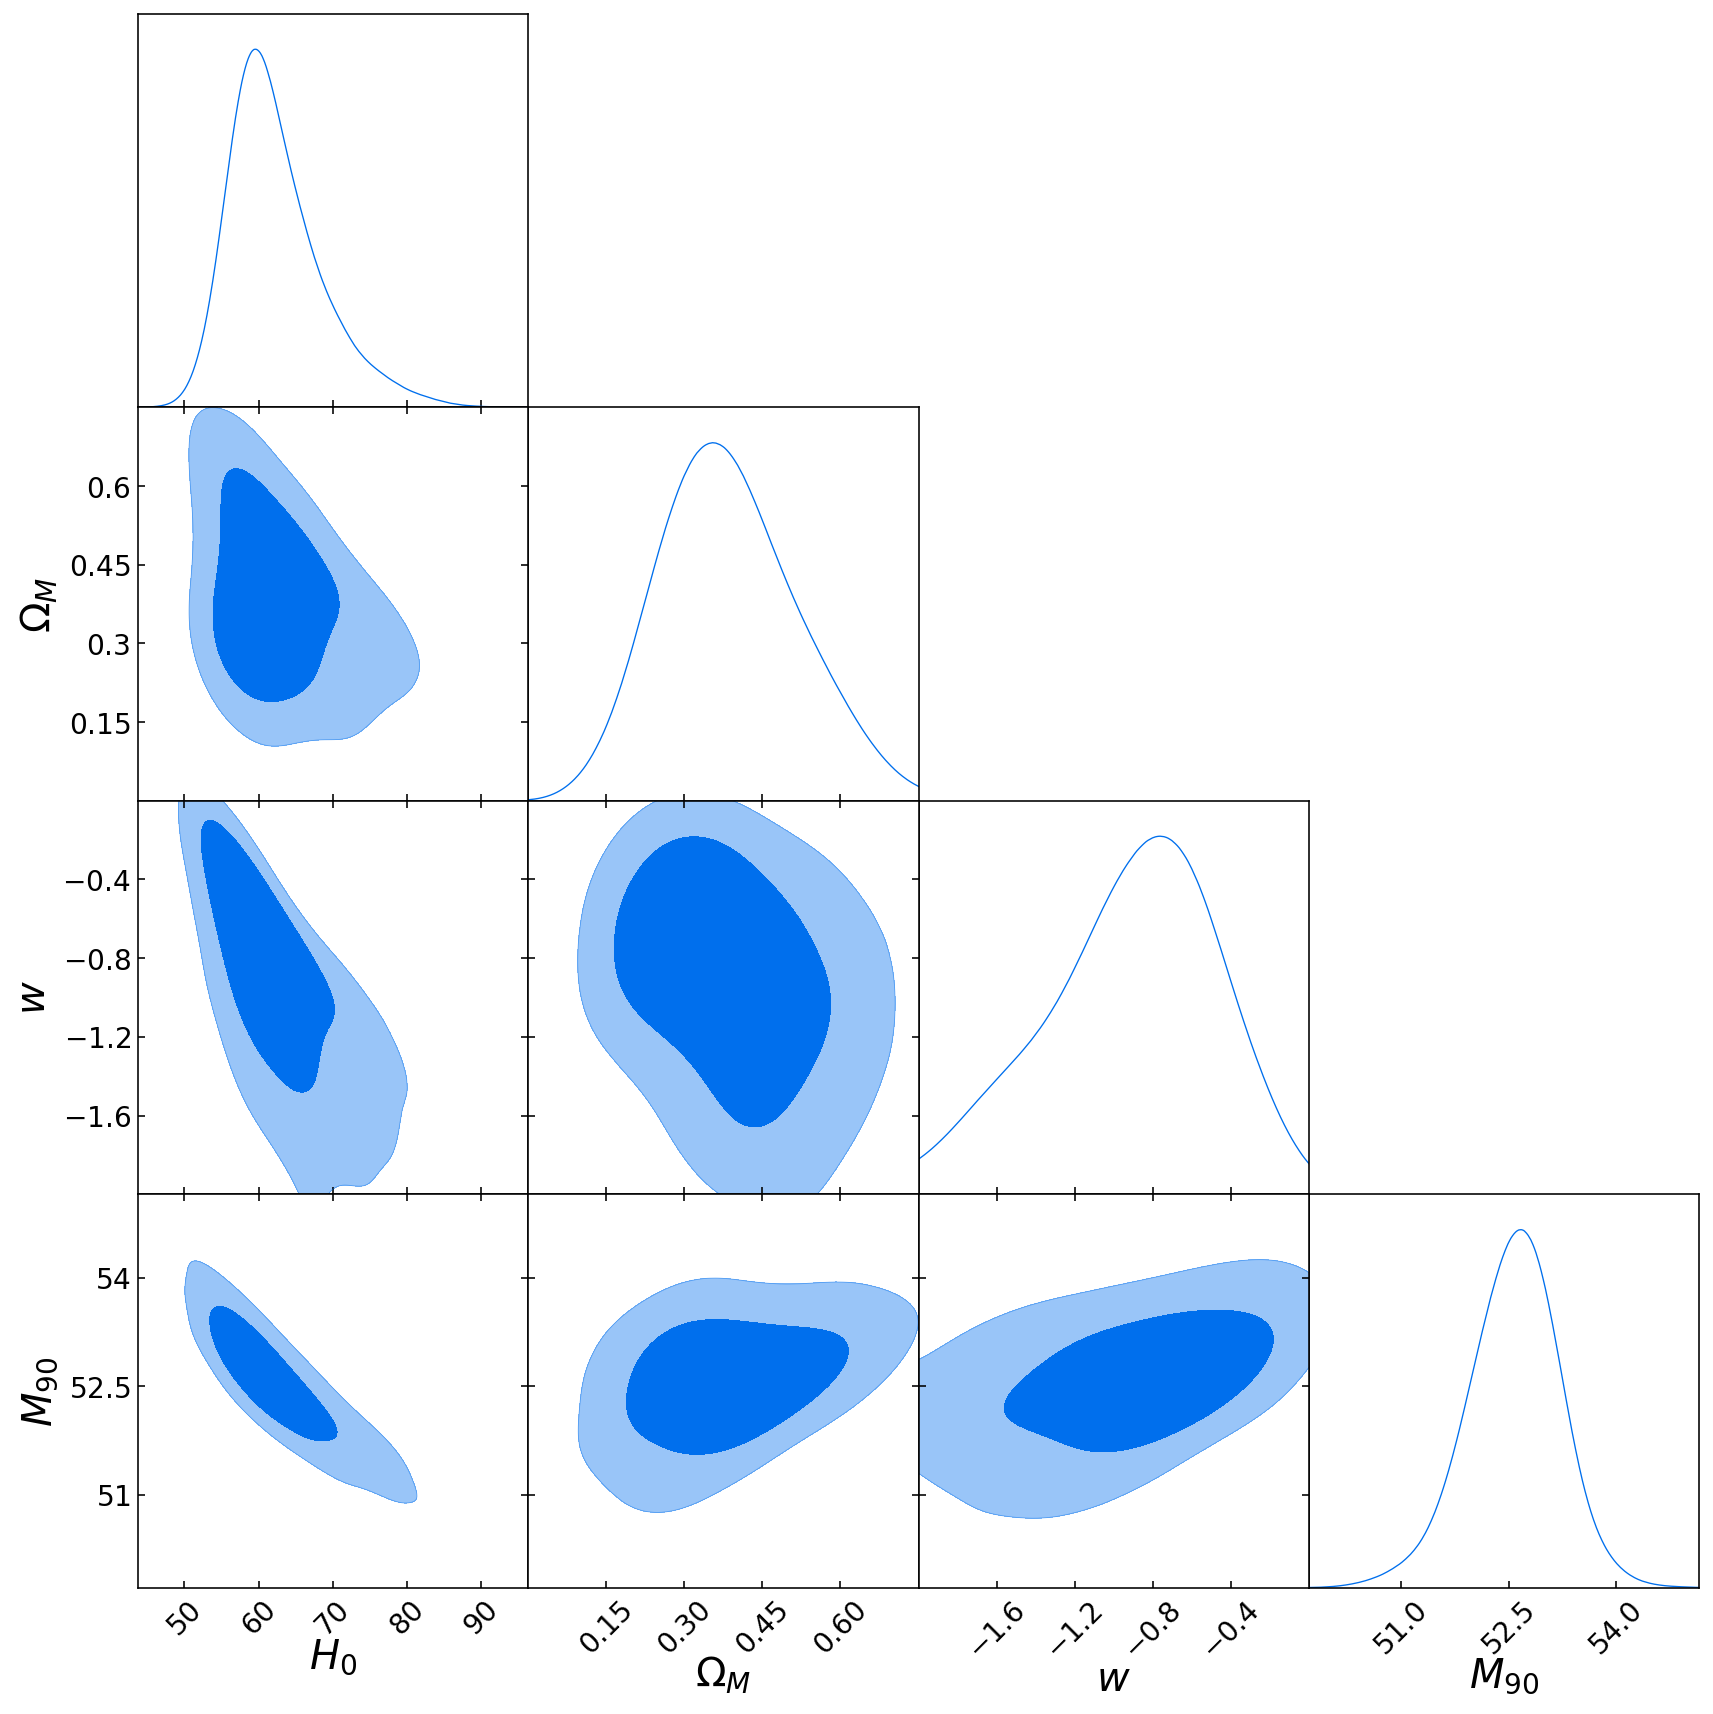

Population 1/5
Sampling proposal density...
Done.


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


Sampling approximate posterior...
Done.
Removed no burn in


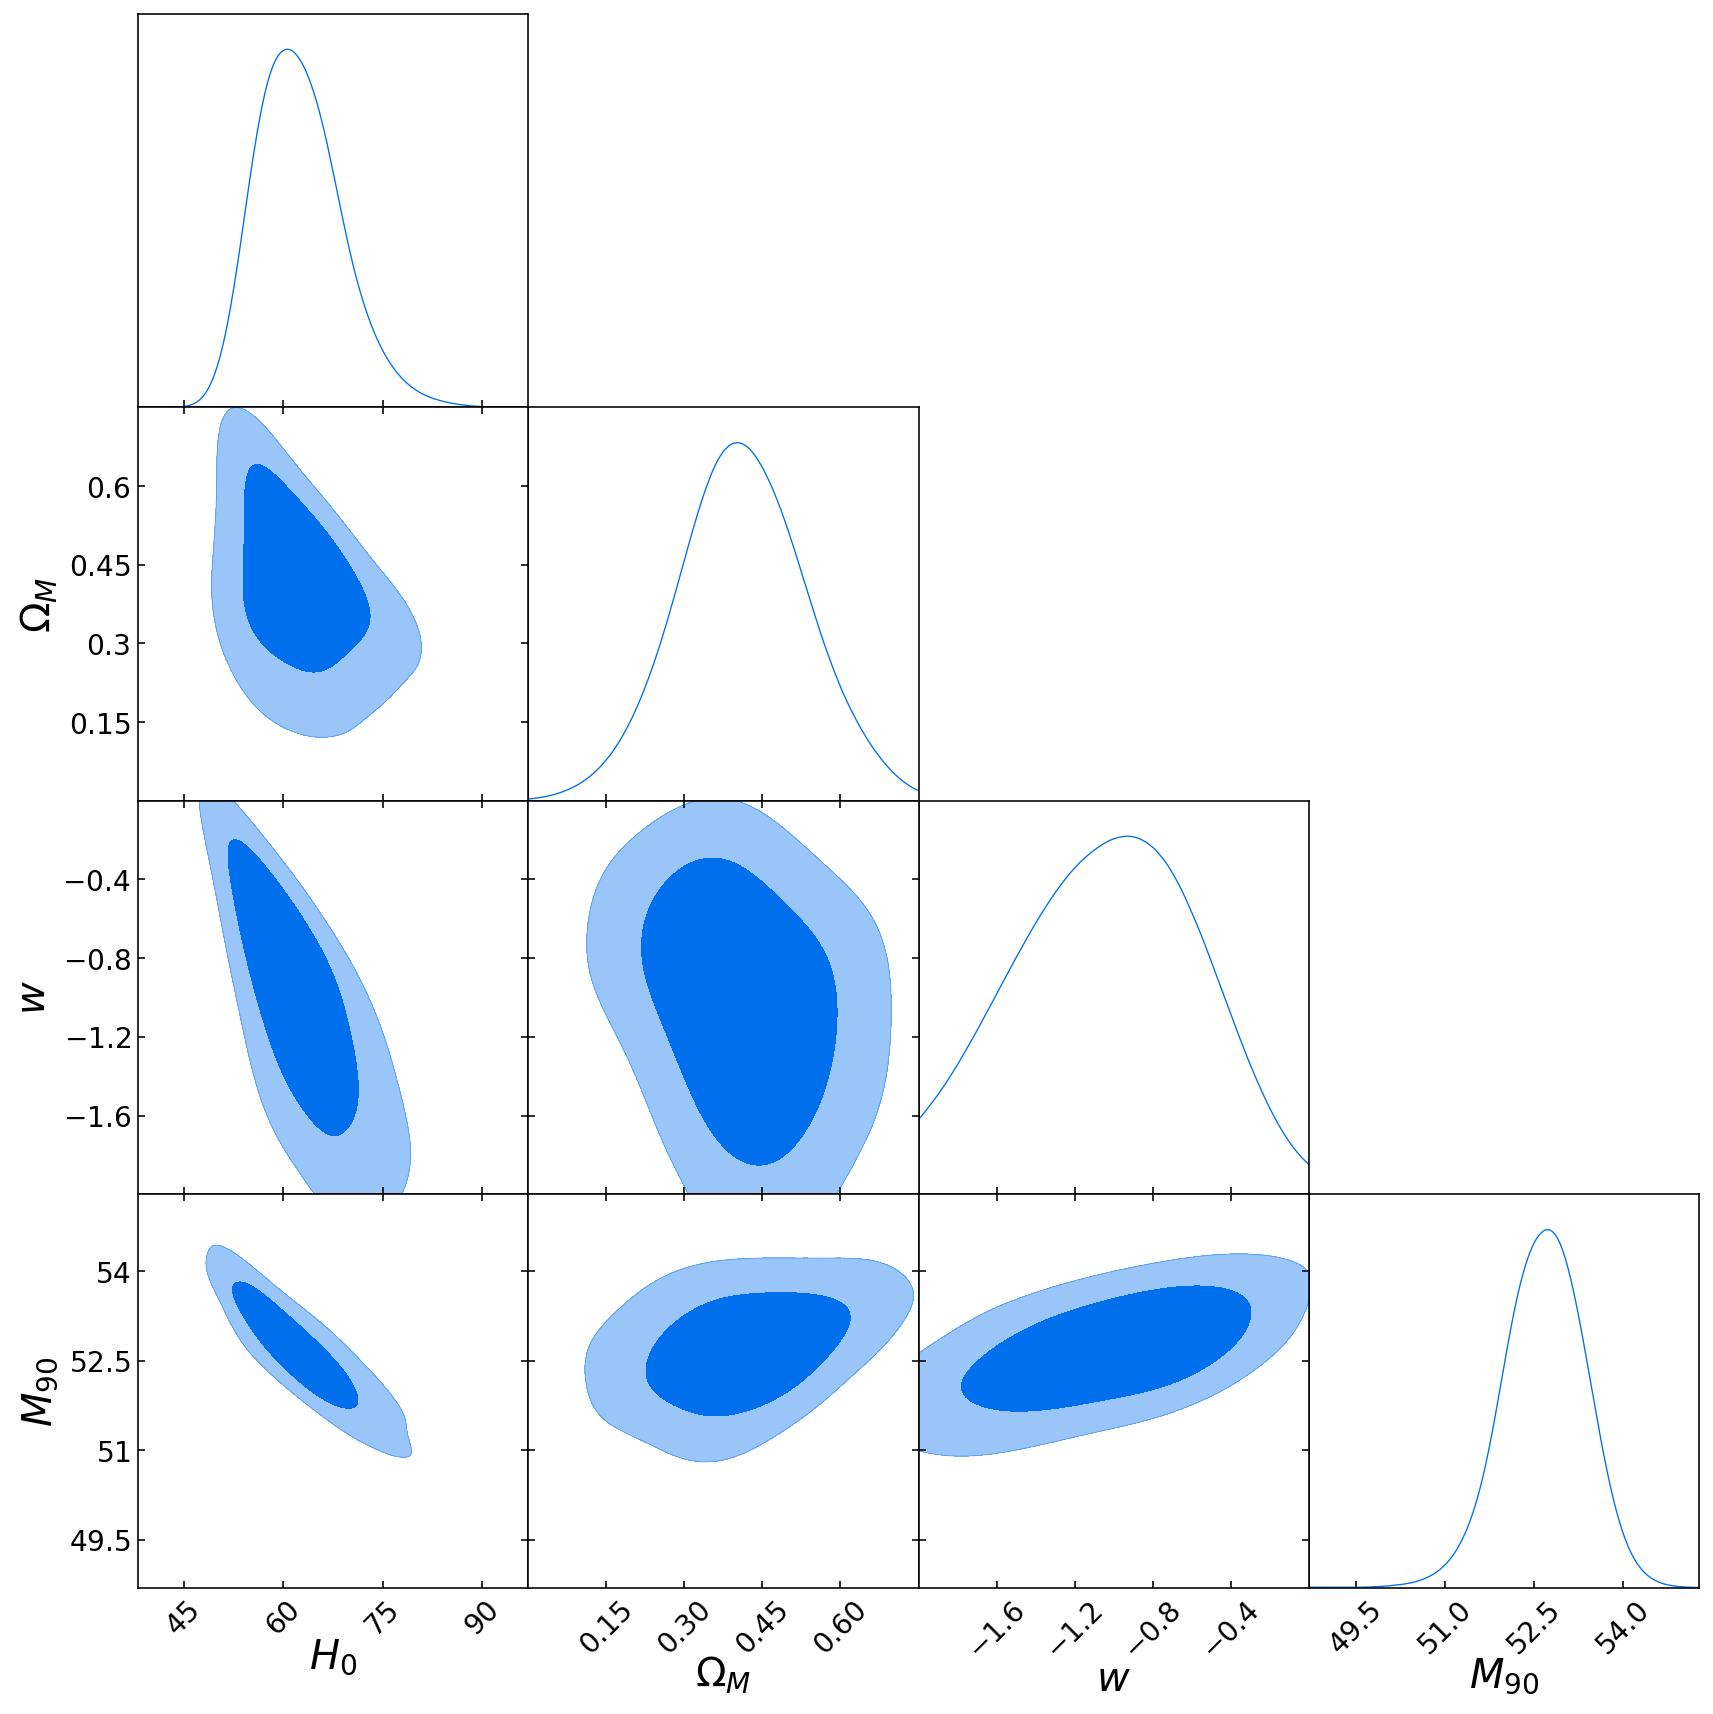

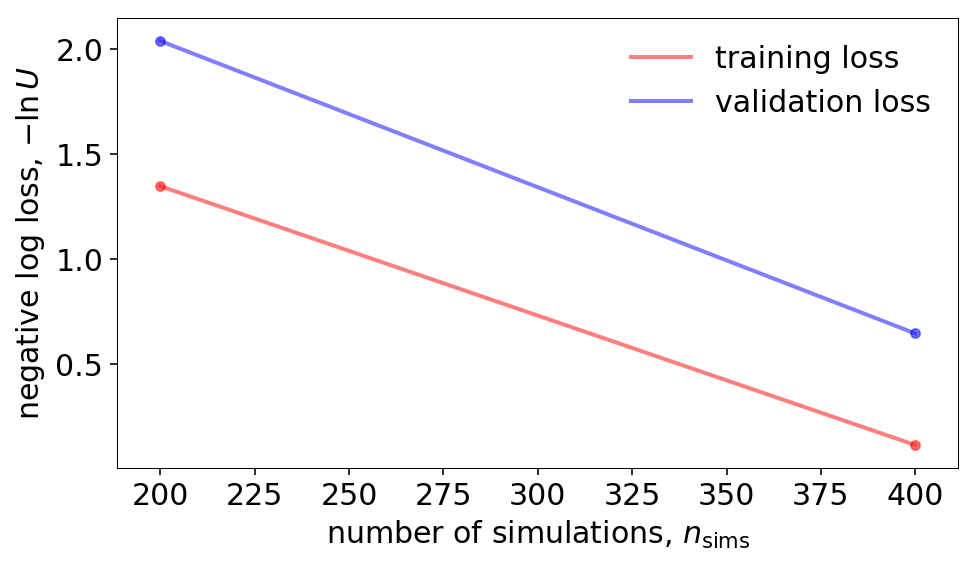

Population 2/5
Sampling proposal density...
Done.


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


Sampling approximate posterior...
Done.
Removed no burn in


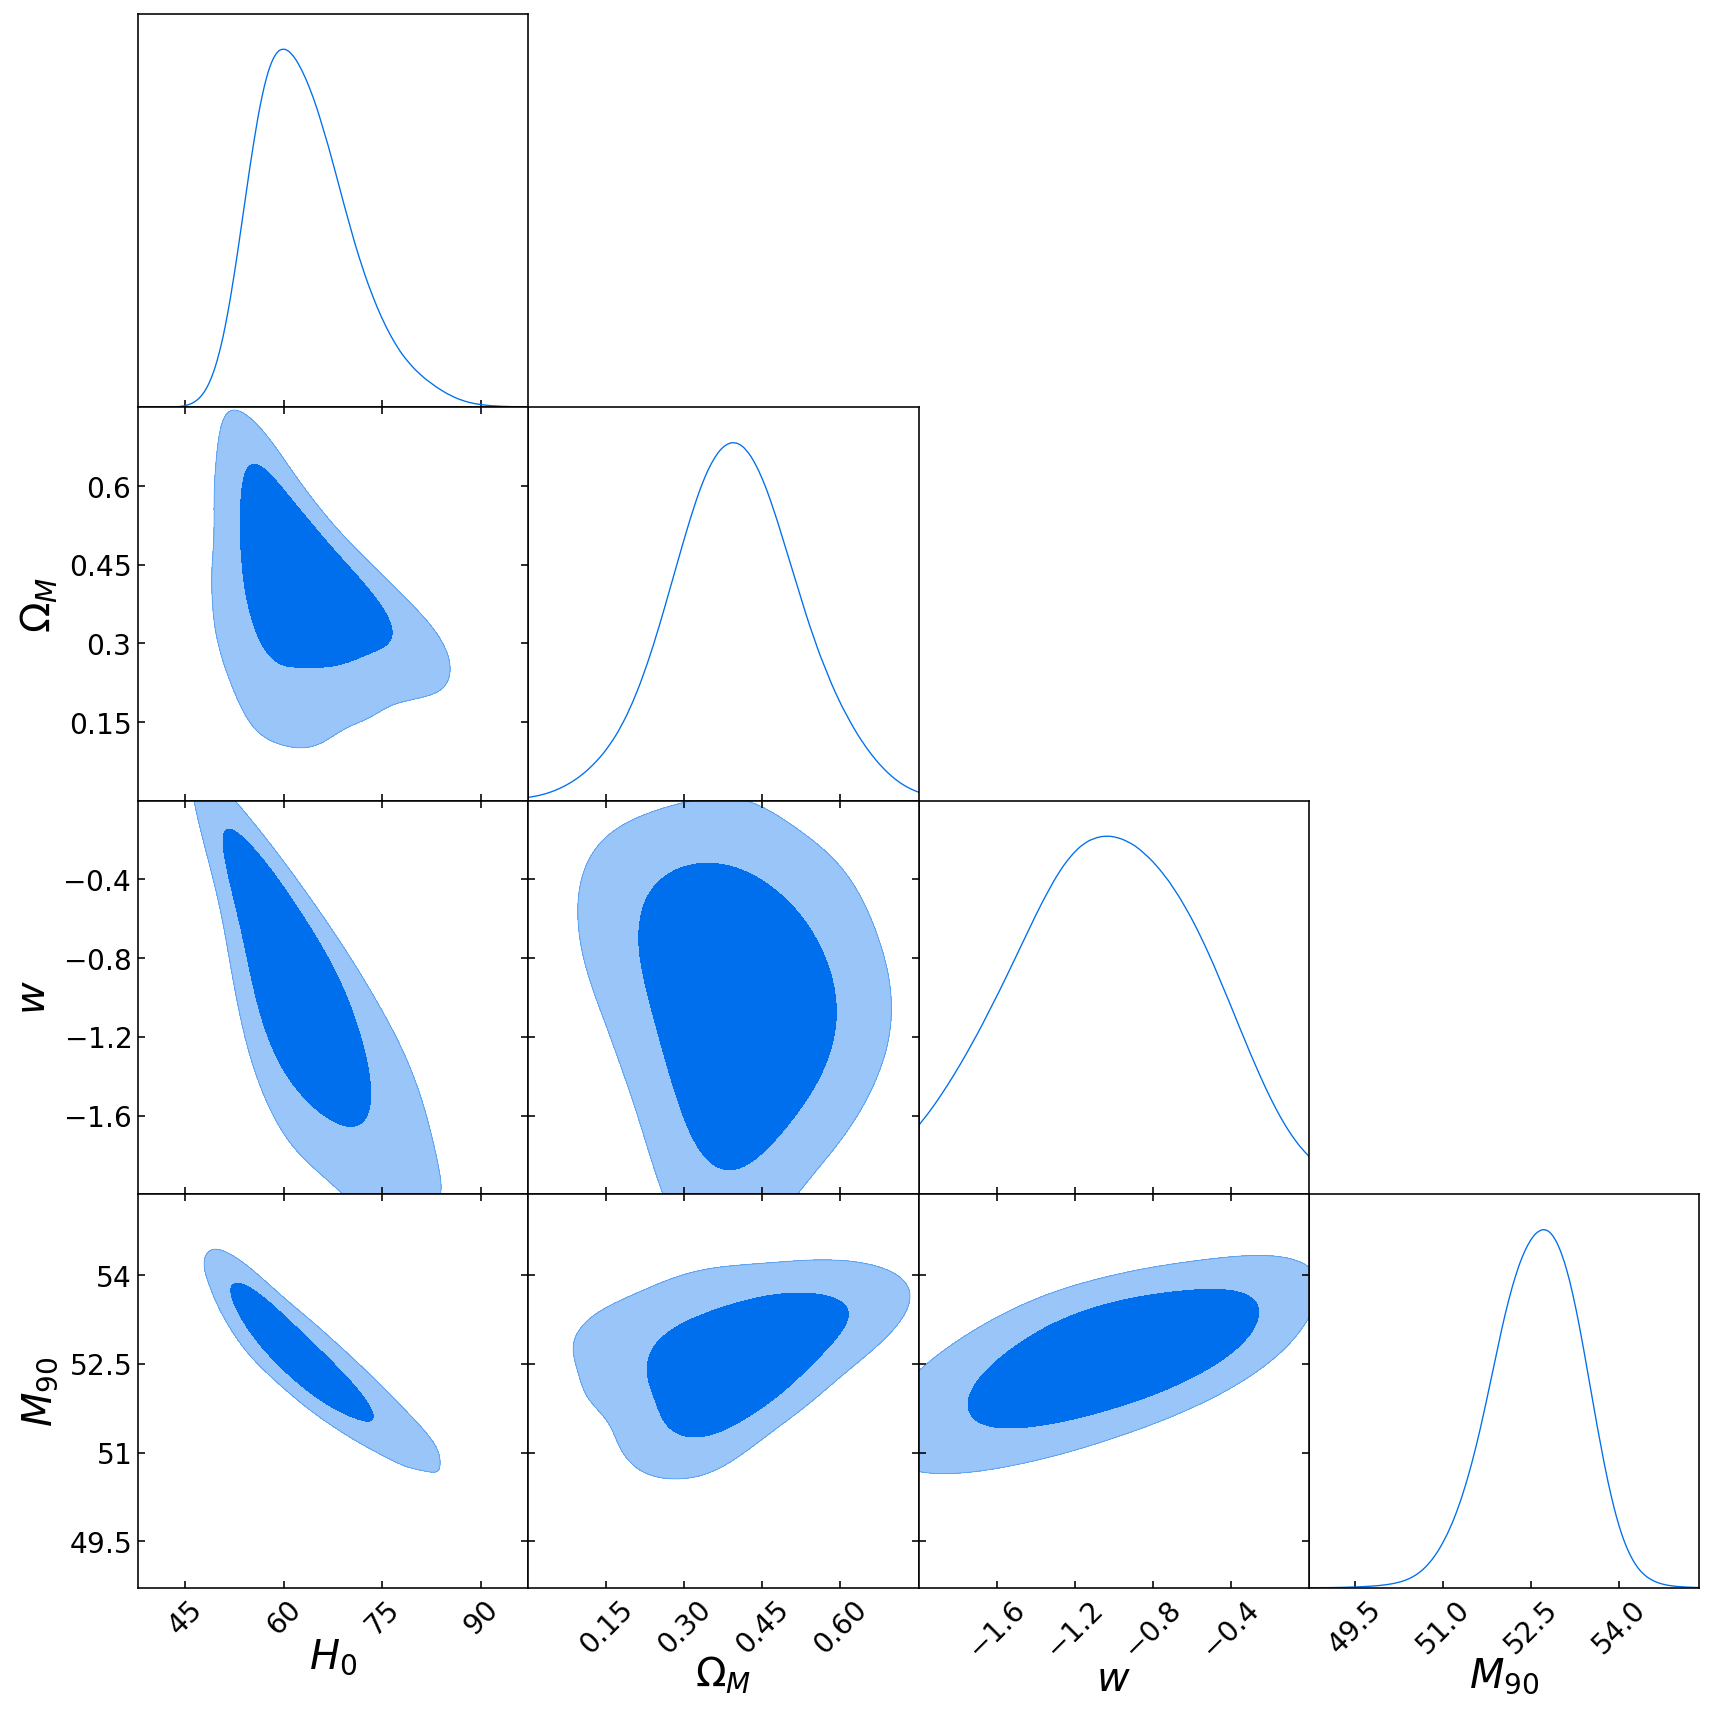

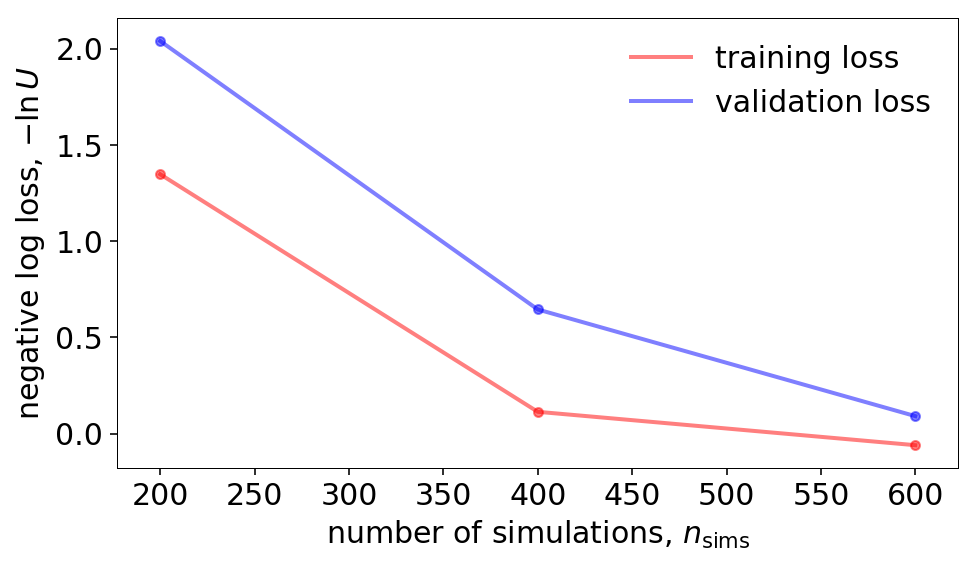

Population 3/5
Sampling proposal density...
Done.


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


Sampling approximate posterior...
Done.
Removed no burn in


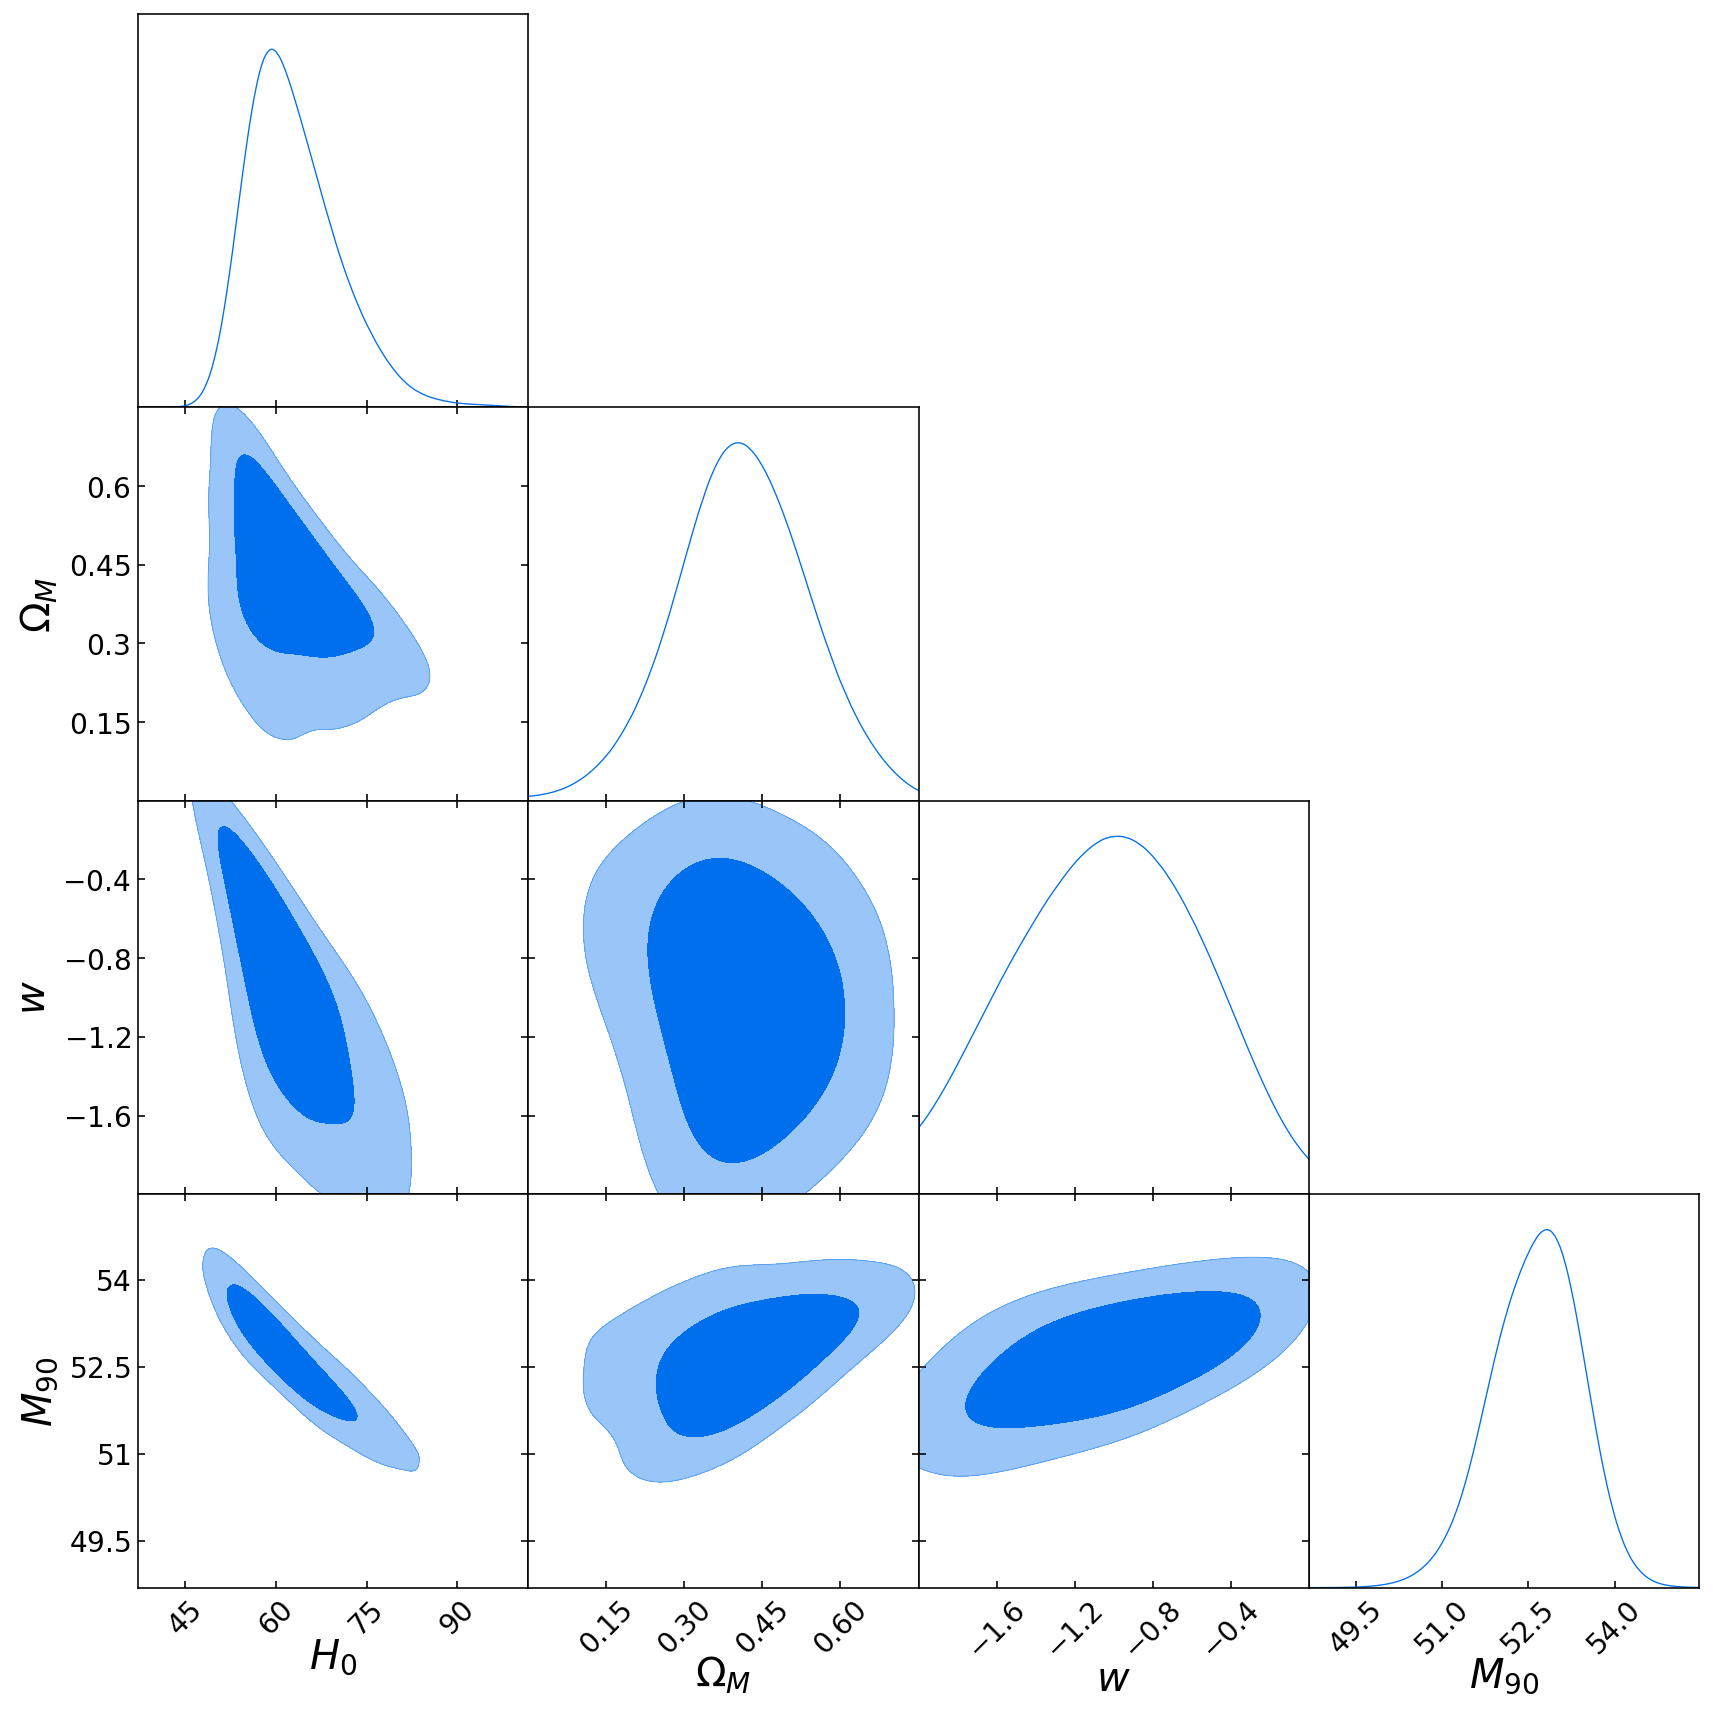

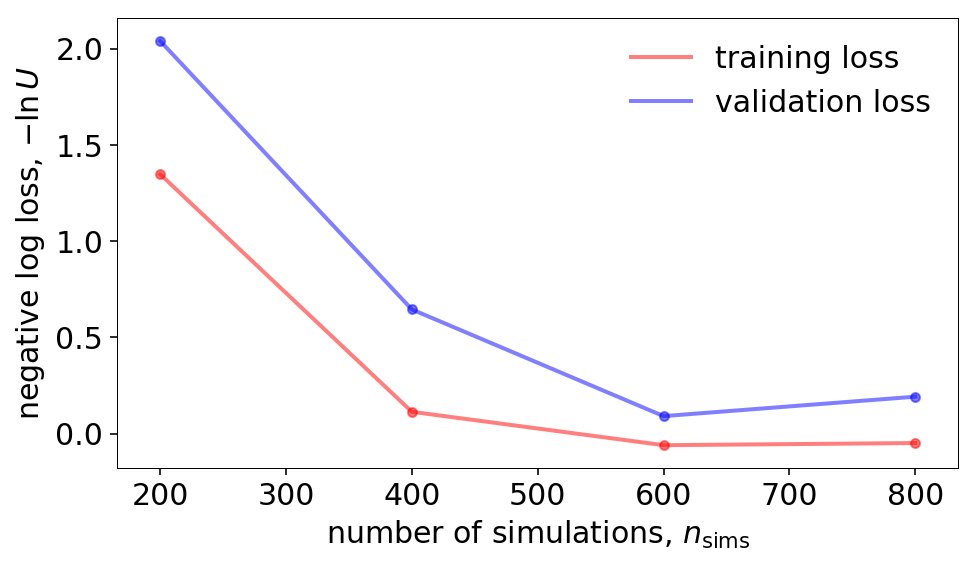

Population 4/5
Sampling proposal density...
Done.


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


Sampling approximate posterior...
Done.
Removed no burn in


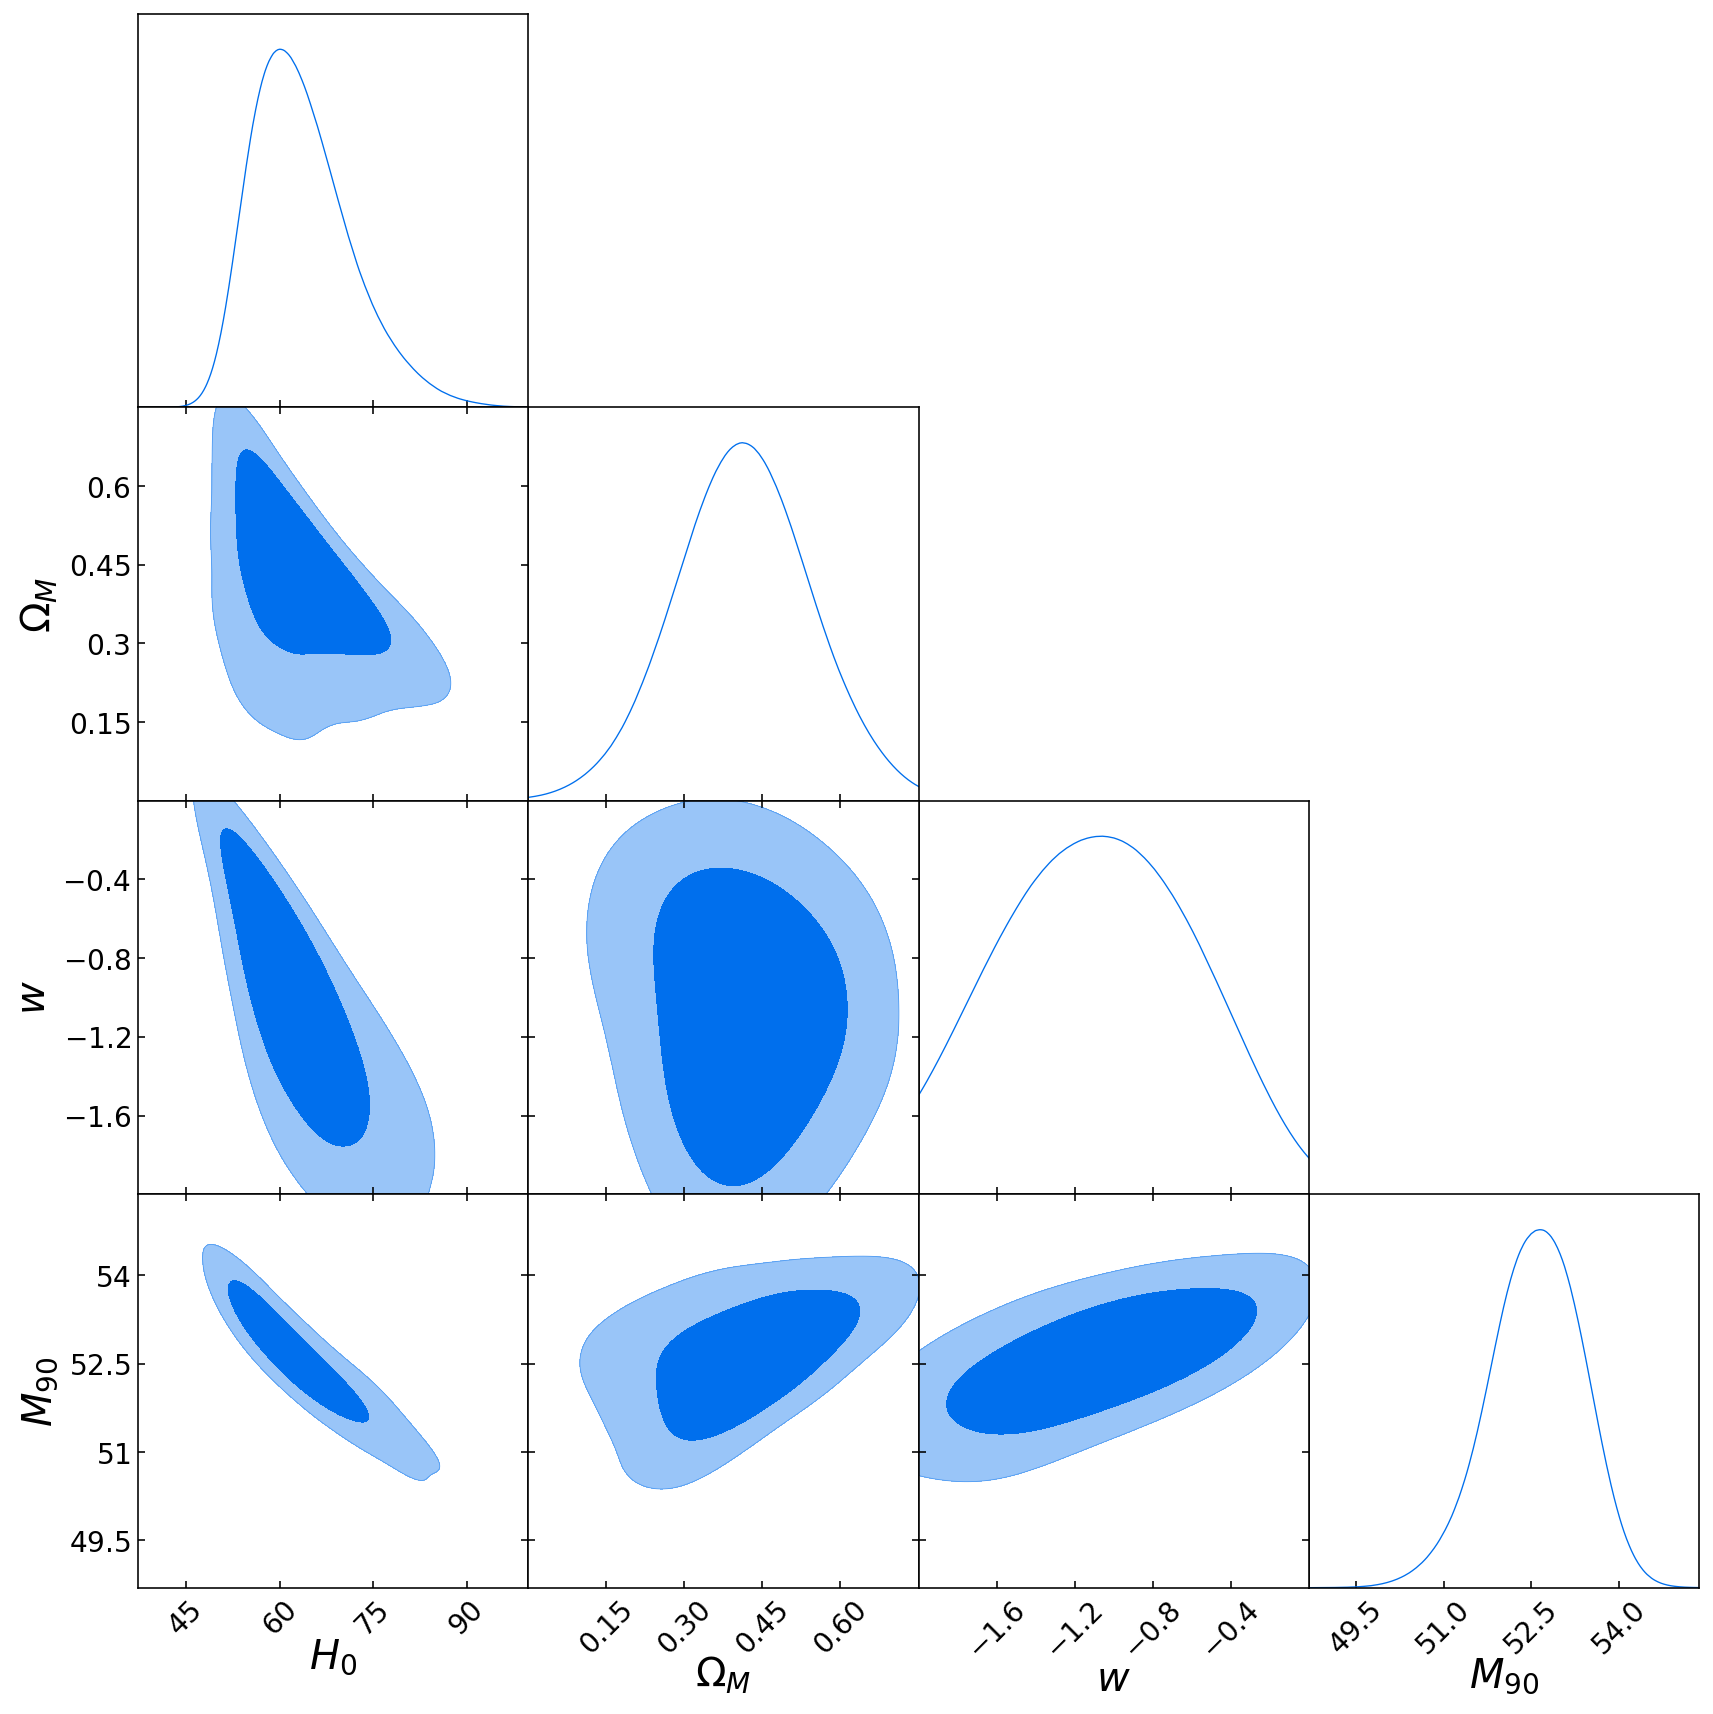

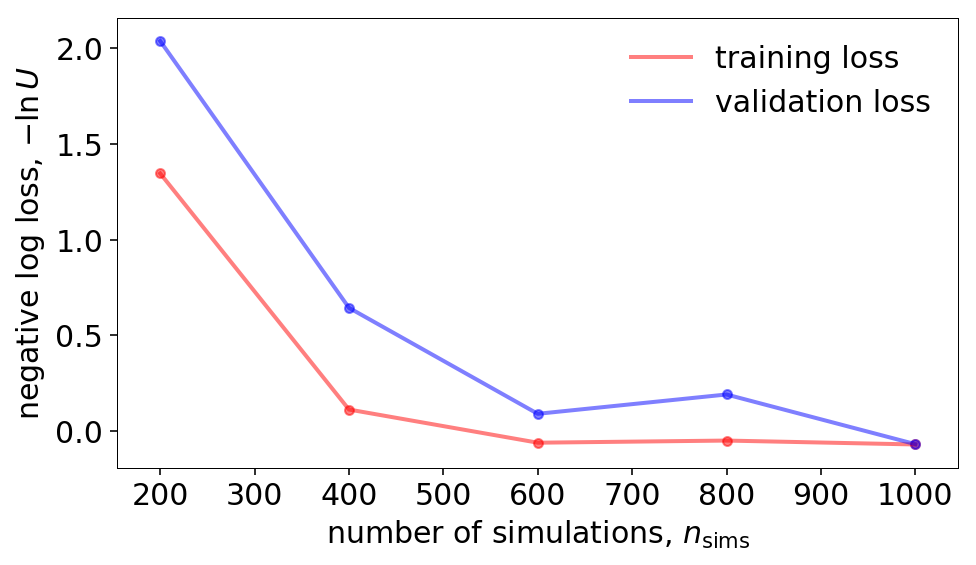

Population 5/5
Sampling proposal density...
Done.


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


INFO:tensorflow:Restoring parameters from ./LFI/graph_checkpoint


Sampling approximate posterior...
Done.
Removed no burn in


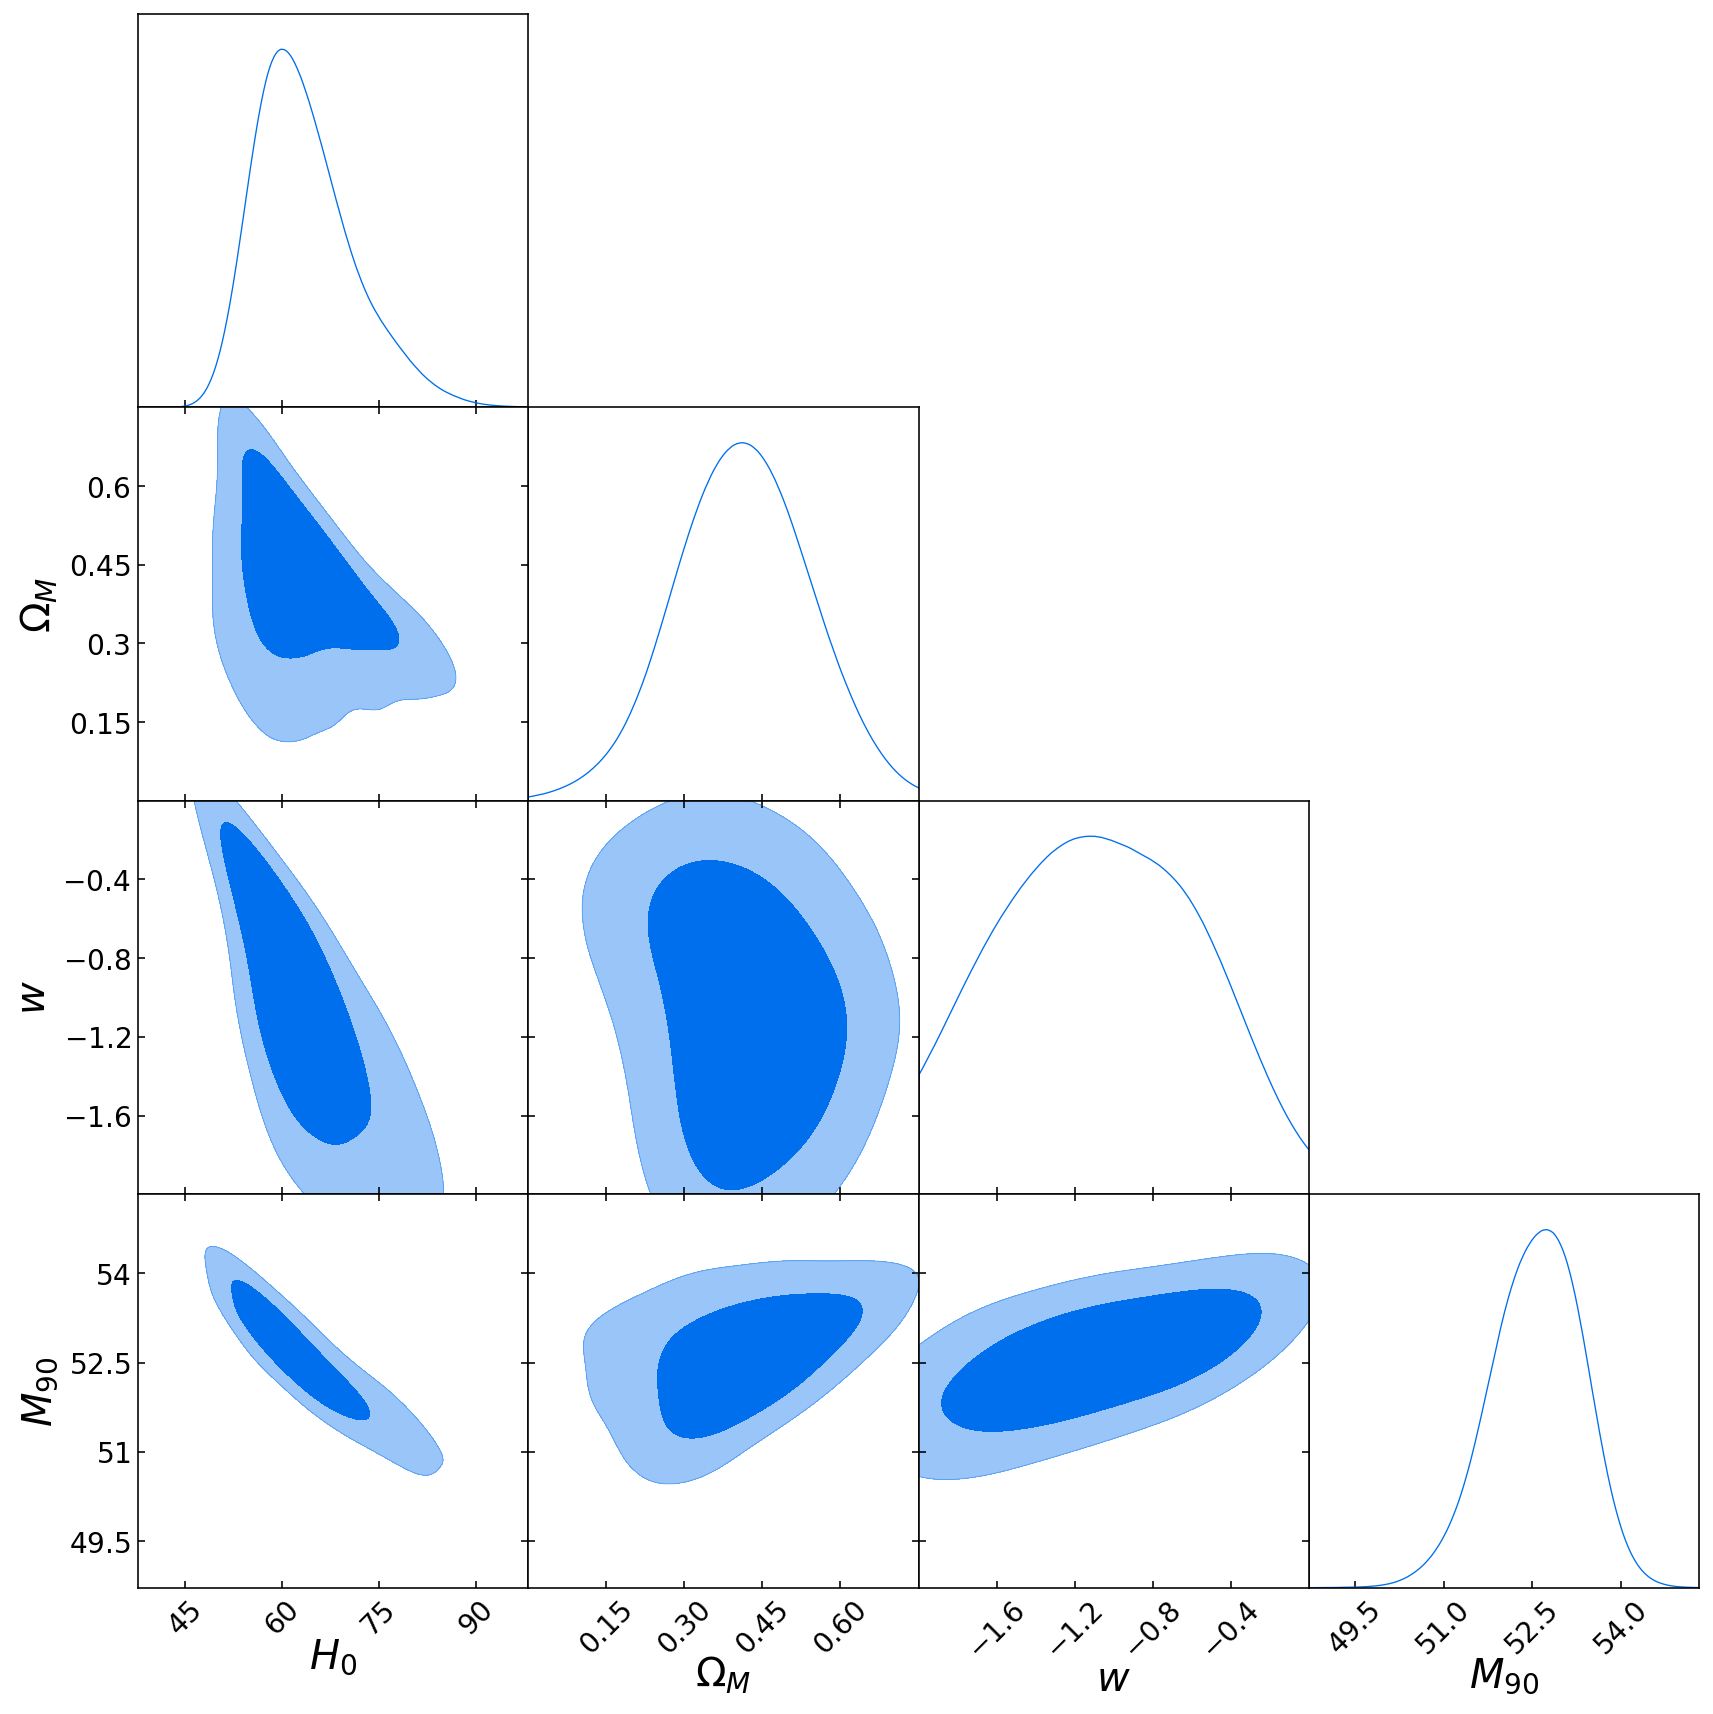

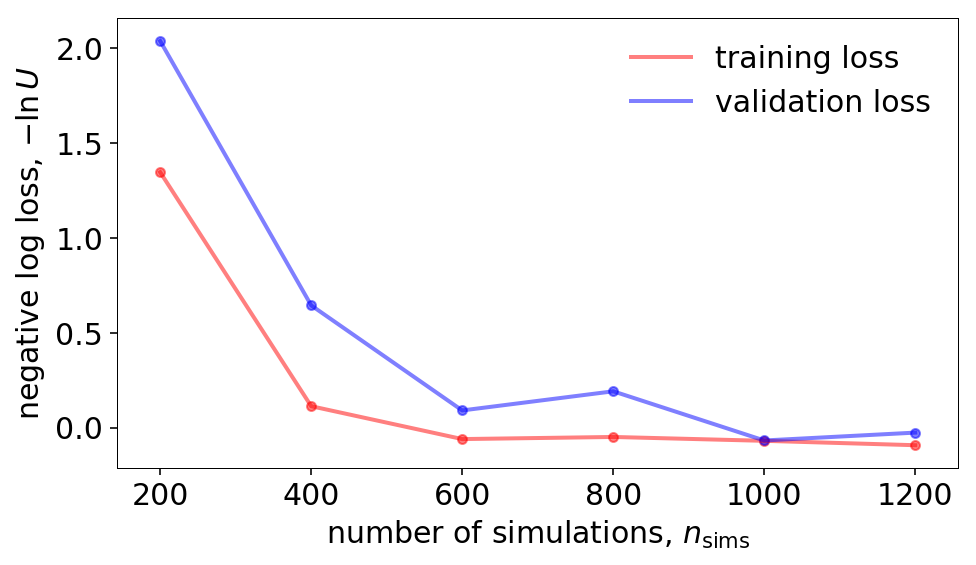

In [16]:
# Initial samples, batch size for population samples, number of populations
n_initial = 200
n_batch = 200
n_populations = 5

# Do the SNL training
DelfiEnsemble.sequential_training(simulator, compress, n_initial, n_batch, n_populations, patience=10,
                       save_intermediate_posteriors=True)

In [9]:
with open('LFI/posterior_samples_5.dat', 'r') as f:
    post = loadtxt(f)

In [10]:
zs = linspace(0, 2, 1000)
Hzs = []
for p in post:
    c = cosmo.FlatwCDM(p[0]*u.km/u.s/u.Mpc, p[1], p[2])
    Hzs.append(c.H0.to(u.km/u.s/u.Mpc).value*c.efunc(zs))
Hzs = array(Hzs)

Text(0, 0.5, '$H(z)$ ($\\mathrm{km} \\, \\mathrm{s}^{-1} \\, \\mathrm{Mpc}^{-1}$)')

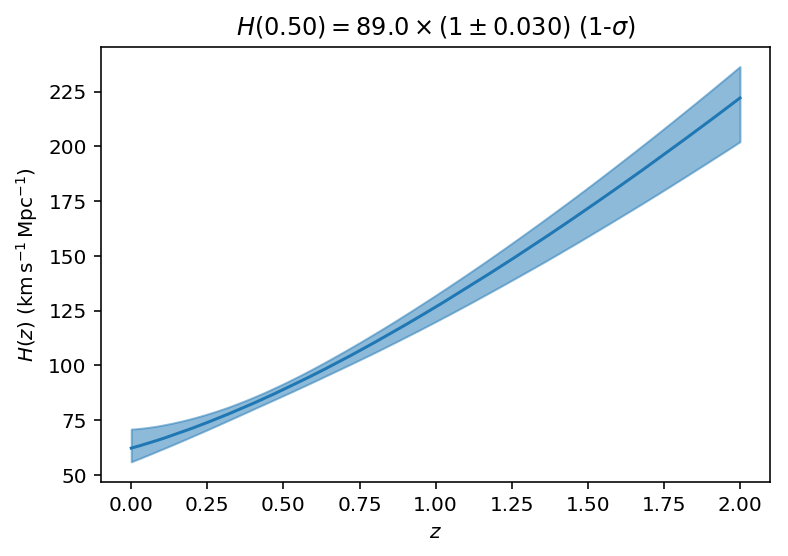

In [28]:
h = percentile(Hzs, 84, axis=0)
l = percentile(Hzs, 16, axis=0)
m = median(Hzs, axis=0)

line, = plot(zs, m)
fill_between(zs, h, l, color=line.get_color(), alpha=0.5)

imin = argmin((h-l)/(2*m))
zmin = zs[imin]
Hmin = m[imin]
smin = (h[imin]-l[imin])/(2*m[imin])

title(r'$H\left({:.2f}\right) = {:.1f} \times \left(1 \pm {:.3f} \right)$ (1-$\sigma$)'.format(zmin, Hmin, smin))
xlabel(r'$z$')
ylabel(r'$H(z)$ ($\mathrm{km} \, \mathrm{s}^{-1} \, \mathrm{Mpc}^{-1}$)')

In [37]:
H0 = Planck15.H0.to(u.km/u.s/u.Mpc).value
Om = Planck15.Om0

log_wts = ss.norm(H0P, 0.01*H0P).logpdf(post[:,0]) + ss.norm(Om*(H0P/100)**2, sqrt(0.00016**2 + 0.0015**2)).logpdf(post[:,1]*(post[:,0]/100)**2) + 2.0*log(post[:,0]/100.0) - ss.norm(H0, sqrt(prior_C[0,0])).logpdf(post[:,0]) - ss.norm(Om, sqrt(prior_C[1,1])).logpdf(post[:,1])
wts = exp(log_wts - np.max(log_wts))
rs = random.uniform(size=len(wts))
s = rs < wts

post_cosmo = post[s, :]

print('w = {:.2f} +/- {:.2f}'.format(mean(post_cosmo[:,2]), std(post_cosmo[:,2])))

w = -1.01 +/- 0.15
